In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from geopy.distance import geodesic
from matplotlib import pyplot as plt

In [4]:
#TODO: delete
airTraffic_df = pd.read_csv("data/air_traffic.csv")
avgFare_df = pd.read_csv("data/quarterly_avg_air_fare.csv")
carriers_df = pd.read_csv("data/carriers_routes.csv")
#Main dataframe we are using
faresByCity_df = pd.read_csv("data/city_pair_fares.csv")

In [5]:
#I don't think this dataset is going to be useful for us 
#TODO: Delete
airTraffic_df.head()

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
0,2003,1,"43,032,450","4,905,830","47,938,280","785,160","57,667","842,827","36,211,422","12,885,980","49,097,402","56,191,300","17,968,572","74,159,872",64.44,71.71,66.20
1,2003,2,"41,166,780","4,245,366","45,412,146","690,351","51,259","741,610","34,148,439","10,715,468","44,863,907","50,088,434","15,587,880","65,676,314",68.18,68.74,68.31
2,2003,3,"49,992,700","5,008,613","55,001,313","797,194","58,926","856,120","41,774,564","12,567,068","54,341,633","57,592,901","17,753,174","75,346,075",72.53,70.79,72.12
3,2003,4,"47,033,260","4,345,444","51,378,704","766,260","55,005","821,265","39,465,980","10,370,592","49,836,572","54,639,679","15,528,761","70,168,440",72.23,66.78,71.02
4,2003,5,"49,152,352","4,610,834","53,763,186","789,397","55,265","844,662","41,001,934","11,575,026","52,576,960","55,349,897","15,629,821","70,979,718",74.08,74.06,74.07


In [6]:
#Also don't think this dataset is useful should delete
#TODO: DELETE
carriers_df.head()

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,UNIQUE_CARRIER_ENTITY,REGION,CARRIER,...,DEST,DEST_CITY_NAME,DEST_COUNTRY,DEST_COUNTRY_NAME,DEST_WAC,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS
0,0.0,0.0,0.0,19.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,YWH,"Victoria, Canada",CA,Canada,906,2024,2,6,1,L
1,0.0,0.0,0.0,45.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,CXH,"Vancouver, Canada",CA,Canada,906,2024,2,4,1,L
2,0.0,0.0,0.0,47.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,FRD,"Friday Harbor, WA",US,United States,93,2024,2,5,1,L
3,0.0,0.0,0.0,53.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,FBS,"Friday Harbor, WA",US,United States,93,2024,2,5,1,L
4,0.0,0.0,0.0,60.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,ZNA,"Nanaimo, Canada",CA,Canada,906,2024,2,6,1,F


# Dataset Overview

The selected flight dataset is from (https://data.transportation.gov/Aviation/Consumer-Airfare-Report-Table-6-Contiguous-State-C/yj5y-b2ir/about_data) and contains 114,035 records with the following data. The dataset spans multiple years and includes domestic routes across the United States

#### Input Features

1. `distance`: Distance in miles between origin and destination (float)
2. `year`: Year of the flight data (int)
3. `quarter`: Quarter of the year (1-4) (int)
4. `passengers`: Number of passengers on the route (int)
5. `origin`: Origin city code (categorical)
6. `destination`: Destination city code (categorical)
7. `market_share`: Carrier's market share on the route (float between 0-1)
8. `carrier`: Two-letter airline carrier code (categorical)
9. `nsmiles`: Non-stop miles between cities

#### Target Variable
- `fare`: Average ticket fare in USD (float)

In [7]:
# Get dataset dimensions
rows, columns = faresByCity_df.shape
print(f"\nDataset size: {rows:,} rows × {columns} columns")

# Show all column names
print("\nColumns in faresByCity_df:")
for col in faresByCity_df.columns:
    print(col)

# You can also get both with a single info() call:
print("\nComplete dataset information:")
faresByCity_df.info()


Dataset size: 114,035 rows × 18 columns

Columns in faresByCity_df:
Year
quarter
citymarketid_1
citymarketid_2
city1
city2
nsmiles
passengers
fare
carrier_lg
large_ms
fare_lg
carrier_low
lf_ms
fare_low
table_1_flag
Geocoded_City1
Geocoded_City2

Complete dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114035 entries, 0 to 114034
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Year            114035 non-null  int64  
 1   quarter         114035 non-null  int64  
 2   citymarketid_1  114035 non-null  int64  
 3   citymarketid_2  114035 non-null  int64  
 4   city1           114035 non-null  object 
 5   city2           114035 non-null  object 
 6   nsmiles         114035 non-null  int64  
 7   passengers      114035 non-null  int64  
 8   fare            114035 non-null  float64
 9   carrier_lg      114035 non-null  object 
 10  large_ms        114035 non-null  float64
 11  fare_lg  

#### Model Attributes and Feature Selection

We decided that the following of these attributes are important for our predictive model

1. **Origin City** (`origin`): The departure city for the flight route
2. **Destination City** (`destination`): The arrival city for the flight route
3. **Quarter** (`quarter`): The quarter of the year (1-4) to capture seasonal pricing patterns
4. **Number of Passengers** (`passengers`): The passenger volume on the route
5. **Carrier** (`carrier`): The airline operating the flight
6. **NsMiles** (`nsmiles`): The number of non stop miles between the two locations

Additional derived features our model uses internally:
- **Market Share**: Airline's market share for the specific route

These features were chosen due to their strong correlation with fare prices and their ability to capture different aspects of airline pricing dynamics including geographic locations and competition

## Preliminary Analysis Charts

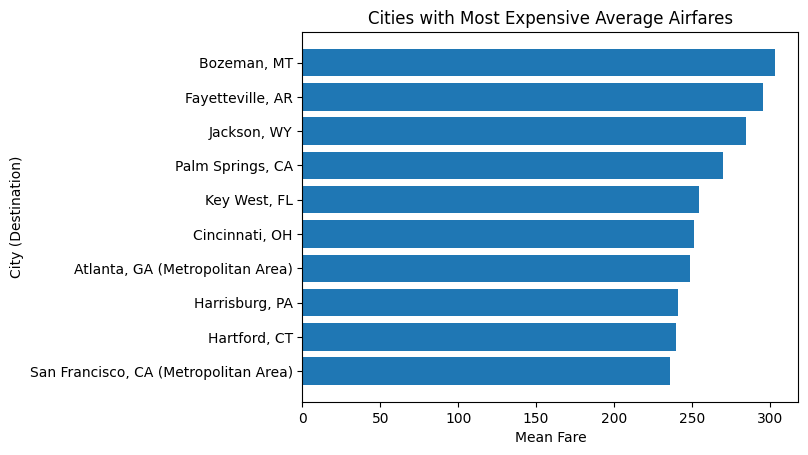

In [8]:
'''Cities with most expensive fares '''
c1_df = faresByCity_df.groupby('city2')['fare'].mean()
c1_df_sorted = c1_df.sort_values().reset_index()

x = c1_df_sorted.tail(10)['city2']
y = c1_df_sorted.tail(10)['fare']

plt.title('Cities with Most Expensive Average Airfares')
plt.barh(x,y)
plt.xlabel("Mean Fare")
plt.ylabel("City (Destination)")
plt.show()

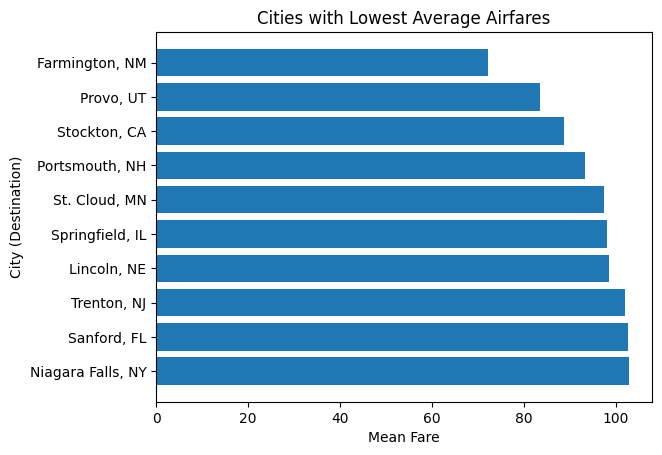

In [9]:
''' Chart 2: Cities with least expensive fares '''
c1_df = faresByCity_df.groupby('city2')['fare'].mean()
c1_df_sorted = c1_df.sort_values(ascending=False).reset_index()
x = c1_df_sorted.tail(10)['city2']
y = c1_df_sorted.tail(10)['fare']
plt.barh(x,y)
plt.title('Cities with Lowest Average Airfares') 
plt.xlabel("Mean Fare")
plt.ylabel("City (Destination)")
plt.show()

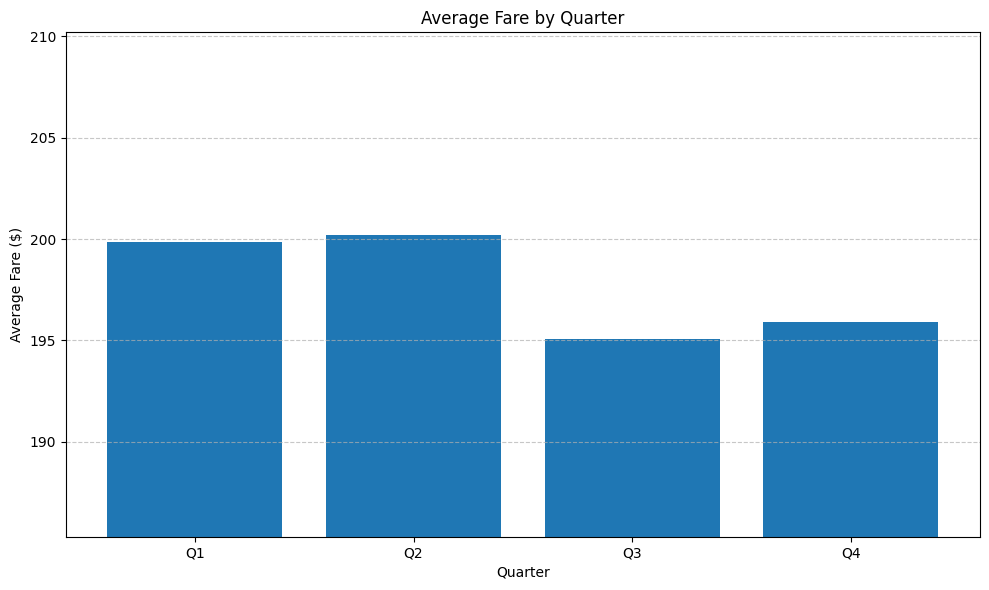

In [10]:
def plot_quarterly_fares(faresByCity_df):
    quarterly_avg = faresByCity_df.groupby('quarter')['fare'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    
    plt.bar(quarterly_avg['quarter'], quarterly_avg['fare'])
    
    plt.xlabel('Quarter')
    plt.ylabel('Average Fare ($)')
    plt.title('Average Fare by Quarter')
    
    plt.xticks(quarterly_avg['quarter'], [f'Q{q}' for q in quarterly_avg['quarter']])
    
    # Adjust y-axis to zoom in on the data range
    min_fare = quarterly_avg['fare'].min() * 0.95
    max_fare = quarterly_avg['fare'].max() * 1.05 
    plt.ylim(min_fare, max_fare)
    
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()

plot_quarterly_fares(faresByCity_df)

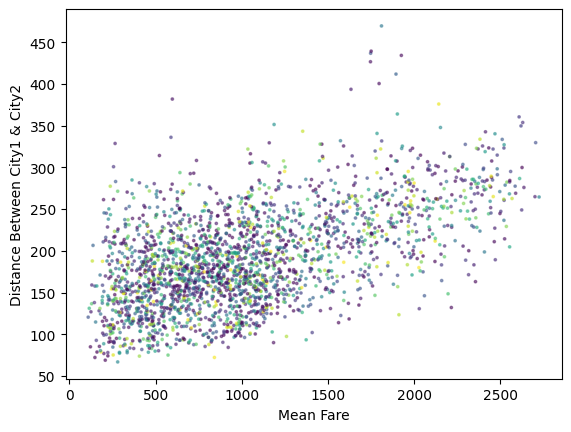

2433


In [11]:
'''Chart 4: Scatter plot by airfare/distance per route'''
def scatter_fare_distance(faresByCity_df):
    faresByRoute= faresByCity_df.groupby(['city1', 'city2','nsmiles'])['fare'].mean()
    faresByRoute_sorted = faresByRoute.sort_values().reset_index()
    
    x = faresByRoute_sorted['nsmiles']
    y = faresByRoute_sorted['fare']
    
    colors = 30*(np.random.rand(len(faresByRoute_sorted))**2)
    area = 3
    
    plt.scatter(x,y, s=area, c=colors,alpha=0.5)
    plt.xlabel("Mean Fare")
    plt.ylabel("Distance Between City1 & City2")
    plt.show()

    print(len(faresByRoute_sorted))

scatter_fare_distance(faresByCity_df)

## Clustering Based Outlier Detection

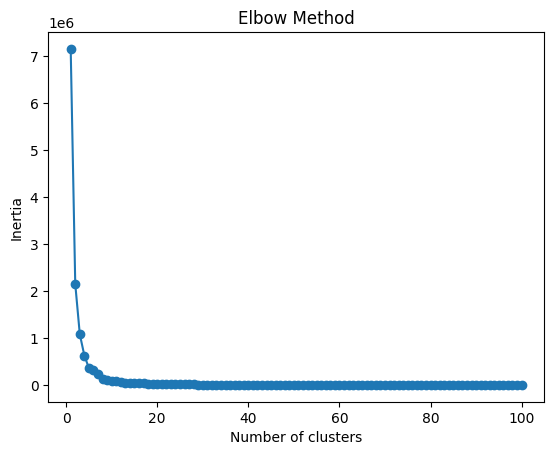

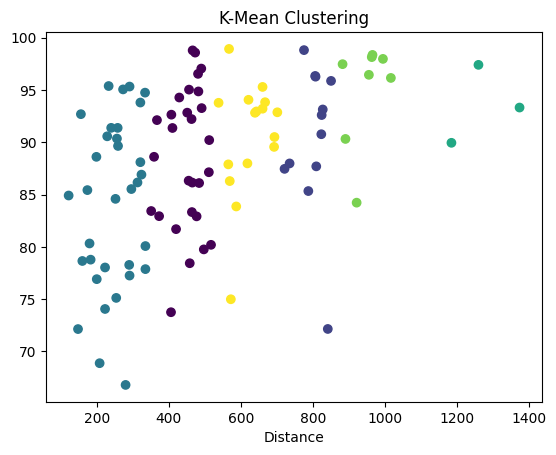

In [12]:
'''Chart 5: K-mean Clustering by airfare/distance per route'''

def plot_k_cluster_price_distance(faresByRoute,x,y):
    # Group, take avg. of fares by city. Sort by fare, asc. #
    faresByRoute= faresByCity_df.groupby(['city1', 'city2','nsmiles'])['fare'].mean()
    faresByRoute_sorted = faresByRoute.sort_values().reset_index()

    N = 100
    data = list(zip(faresByRoute_sorted.head(N)['nsmiles'], faresByRoute_sorted.head(N)['fare']))
    inertias = []
    

    for i in range(1, len(data)+1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.plot(range(1,len(data)+1), inertias,  marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()
    
    x = faresByRoute_sorted.head(N)['nsmiles']
    y = faresByRoute_sorted.head(N)['fare']
    
    kmeans = KMeans(n_clusters = 6)
    kmeans.fit(data)

    plt.scatter(x,y, c=kmeans.labels_)
    plt.title('K-Mean Clustering')
    plt.xlabel('Distance')
    plt.ylabel('')
    plt.show()
    

plot_k_cluster_price_distance(faresByCity_df,x,y)

## Reconstruction Based Outlier Detection

In [13]:
faresByRoute = faresByCity_df.groupby(['city1', 'city2', 'nsmiles'], as_index=False)['fare'].mean()
faresByRoute.rename(columns={'fare': 'avg_fare'}, inplace=True)

data = faresByRoute[['nsmiles', 'avg_fare']].to_numpy()  
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Perform TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_data = svd.fit_transform(data)  
reconstructed_data = svd.inverse_transform(reduced_data)  

reconstruction_error = np.linalg.norm(data - reconstructed_data, axis=1)

svd_outliers = np.argsort(reconstruction_error)[-10:]
print("Top 10 outliers based on reconstruction error:")
print(svd_outliers)
outlier_routes = faresByRoute.iloc[svd_outliers]
print("Outlier routes:")
print(outlier_routes)
from scipy.stats import zscore

# Compute Z-scores for average fare
faresByRoute['z_fare'] = zscore(faresByRoute['avg_fare'])

# Label high and low outliers
faresByRoute['outlier_type'] = 'None'
faresByRoute.loc[faresByRoute['z_fare'] > 3, 'outlier_type'] = 'High Outlier'
faresByRoute.loc[faresByRoute['z_fare'] < -3, 'outlier_type'] = 'Low Outlier'

# Extract outliers
high_outliers = faresByRoute[faresByRoute['outlier_type'] == 'High Outlier']
low_outliers = faresByRoute[faresByRoute['outlier_type'] == 'Low Outlier']

print("High Outliers:")
print(high_outliers)

print("\nLow Outliers:")
print(low_outliers)


Top 10 outliers based on reconstruction error:
[2301  172 1742 2212 2219 2061 2224  438 1554 1775]
Outlier routes:
                                      city1  \
2301                           Portland, OR   
172         Atlanta, GA (Metropolitan Area)   
1742    Los Angeles, CA (Metropolitan Area)   
2212                       Philadelphia, PA   
2219                       Philadelphia, PA   
2061  New York City, NY (Metropolitan Area)   
2224                       Philadelphia, PA   
438          Boston, MA (Metropolitan Area)   
1554                       Jacksonville, FL   
1775    Los Angeles, CA (Metropolitan Area)   

                                      city2  nsmiles    avg_fare  
2301     Washington, DC (Metropolitan Area)     2358  280.122193  
172                            Portland, OR     2172  317.128333  
1742                            Orlando, FL     2218  245.846346  
2212                           Portland, OR     2406  273.026047  
2219                     Salt La

## Airports Included in our Dataset for model training (Domestic US)

Note: There is not a flight between each combination of these origin and destination cities

In [59]:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  

# Then print your cities
origin_cities = sorted(faresByCity_df['city1'].unique())
destination_cities = sorted(faresByCity_df['city2'].unique())
print("Origin Cities:", origin_cities)
print("Destination Cities:", sorted(faresByCity_df['city2'].unique()))

Origin Cities: ['Albany, NY', 'Albuquerque, NM', 'Allentown/Bethlehem/Easton, PA', 'Amarillo, TX', 'Appleton, WI', 'Asheville, NC', 'Ashland, WV', 'Aspen, CO', 'Atlanta, GA (Metropolitan Area)', 'Atlantic City, NJ', 'Austin, TX', 'Bangor, ME', 'Baton Rouge, LA', 'Belleville, IL', 'Bellingham, WA', 'Bend/Redmond, OR', 'Billings, MT', 'Birmingham, AL', 'Bismarck/Mandan, ND', 'Bloomington/Normal, IL', 'Boise, ID', 'Boston, MA (Metropolitan Area)', 'Bozeman, MT', 'Buffalo, NY', 'Bullhead City, AZ', 'Burlington, VT', 'Cedar Rapids/Iowa City, IA', 'Charleston, SC', 'Charlotte, NC', 'Charlottesville, VA', 'Chattanooga, TN', 'Chicago, IL', 'Cincinnati, OH', 'Cleveland, OH (Metropolitan Area)', 'Colorado Springs, CO', 'Columbia, SC', 'Columbus, OH', 'Concord, NC', 'Corpus Christi, TX', 'Dallas/Fort Worth, TX', 'Dayton, OH', 'Daytona Beach, FL', 'Denver, CO', 'Des Moines, IA', 'Detroit, MI', 'Eagle, CO', 'El Paso, TX', 'Eugene, OR', 'Eureka/Arcata, CA', 'Everett, WA', 'Fargo, ND', 'Fayetteville,

## Predictive Models

### Random Forest

#### Helper functions to calculate distance between origin and destination when predicting routes

In [15]:
def calculate_distance(coord1, coord2):
    """Calculate distance between two coordinate pairs"""
    if coord1 is None or coord2 is None:
        return None
    return geodesic(coord1, coord2).miles
    
def extract_coordinates(geocoded_str):
    """Extract coordinates from the geocoded string"""
    if pd.isna(geocoded_str):
        return None
    try:
        # Match coordinates directly using regex
        match = re.search(r'\(([-\d.]+),\s*([-\d.]+)\)', str(geocoded_str))
        if match:
            return (float(match.group(1)), float(match.group(2)))
        return None
    except Exception as e:
        return None

def get_city_coordinates(city, df, is_origin=True):
    """Get coordinates for a city from the dataframe"""
    column = 'Geocoded_City1' if is_origin else 'Geocoded_City2'
    city_data = df[df['city1' if is_origin else 'city2'] == city][column].iloc[0]
    return extract_coordinates(city_data)

#### Clean Data

In [16]:
def prepare_data(faresByCity_df, carriers_df):
   """Prepare data with carrier prices from both carriers"""
   print(f"Initial dataframe shape: {faresByCity_df.shape}")
   
   expanded_rows = []
   
   for _, row in faresByCity_df.iterrows():
       # Add first carrier if fare exists
       if pd.notna(row['fare_lg']):
           expanded_rows.append({
               'city1': row['city1'],
               'city2': row['city2'],
               'nsmiles': row['nsmiles'],
               'year': row['Year'],
               'quarter': row['quarter'],
               'passengers': row['passengers'],
               'carrier': row['carrier_lg'],
               'market_share': row['large_ms'],
               'fare': row['fare_lg'],
               'Geocoded_City1': row['Geocoded_City1'],
               'Geocoded_City2': row['Geocoded_City2']
           })
       
       # Add second carrier if fare exists
       if pd.notna(row['fare_low']):
           expanded_rows.append({
               'city1': row['city1'],
               'city2': row['city2'],
               'nsmiles': row['nsmiles'],
               'year': row['Year'],
               'quarter': row['quarter'],
               'passengers': row['passengers'],
               'carrier': row['carrier_low'],
               'market_share': row['lf_ms'],
               'fare': row['fare_low'],
               'Geocoded_City1': row['Geocoded_City1'],
               'Geocoded_City2': row['Geocoded_City2']
           })
   
   print(f"Number of expanded rows: {len(expanded_rows)}")
   
   # Create DataFrame with both carriers
   expanded_df = pd.DataFrame(expanded_rows)
   print(f"Shape after expansion: {expanded_df.shape}")
   
   # Check for NaN values before dropping
   print("\nColumns with NaN values before dropping:")
   print(expanded_df.isnull().sum())
   
   # Drop any remaining rows with NaN values
   expanded_df = expanded_df.dropna()
   print(f"\nShape after first dropna: {expanded_df.shape}")
   
   # Extract coordinates once and store them
   print("\nExtracting coordinates...")
   expanded_df['origin_coords'] = expanded_df['Geocoded_City1'].apply(extract_coordinates)
   expanded_df['dest_coords'] = expanded_df['Geocoded_City2'].apply(extract_coordinates)
   
   # Check coordinate extraction results
   print("\nNull coordinates after extraction:")
   print(expanded_df[['origin_coords', 'dest_coords']].isnull().sum())
   
   # Drop rows where coordinate extraction failed
   expanded_df = expanded_df.dropna(subset=['origin_coords', 'dest_coords'])
   print(f"\nShape after coordinate extraction: {expanded_df.shape}")
   
   # Create encoders
   origin_encoder = LabelEncoder()
   dest_encoder = LabelEncoder()
   
   # Encode features
   expanded_df['origin_encoded'] = origin_encoder.fit_transform(expanded_df['city1'])
   expanded_df['dest_encoded'] = dest_encoder.fit_transform(expanded_df['city2'])
   carrier_dummies = pd.get_dummies(expanded_df['carrier'], prefix='carrier')
   
   print("\nCreating feature matrix...")
   # Create feature matrix
   X = pd.concat([
       pd.DataFrame({
           'distance': expanded_df['nsmiles'],
           'year': expanded_df['year'],
           'quarter': expanded_df['quarter'],
           'passengers': expanded_df['passengers'],
           'origin': expanded_df['origin_encoded'],
           'destination': expanded_df['dest_encoded'],
           'market_share': expanded_df['market_share']
       }),
       carrier_dummies
   ], axis=1)
   
   print(f"\nFinal X shape: {X.shape}")
   print(f"X columns: {X.columns.tolist()}")
   
   carrier_list = list(expanded_df['carrier'].unique())
   print(f"Number of unique carriers: {len(carrier_list)}")
   print(f"Carriers: {carrier_list}")
   
   # Final check for NaN values in X
   print("\nAny NaN values in final X matrix:")
   print(X.isnull().sum().sum())
   
   return X, expanded_df['fare'], origin_encoder, dest_encoder, carrier_list, expanded_df

#### Encoding categorical variables and create feature matrix

In [17]:
def predict_route_fare(model, origin_city, dest_city, year, quarter, passengers, carrier,
                      origin_encoder, dest_encoder, carrier_list, 
                      faresByCity_df, carriers_df):
    """Predict fare for any city pair with specific carrier"""
    try:
        # Store the exact feature order from training data
        feature_order = ['distance', 'year', 'quarter', 'passengers', 'origin', 'destination', 'market_share',
                        'carrier_9N', 'carrier_A7', 'carrier_AA', 'carrier_AQ', 'carrier_AS', 
                        'carrier_B6', 'carrier_CO', 'carrier_DH', 'carrier_DL', 'carrier_E9', 
                        'carrier_EV', 'carrier_F9', 'carrier_FF', 'carrier_FL', 'carrier_G4', 
                        'carrier_HP', 'carrier_J7', 'carrier_JI', 'carrier_KP', 'carrier_KW', 
                        'carrier_L4', 'carrier_N5', 'carrier_N7', 'carrier_NJ', 'carrier_NK', 
                        'carrier_NW', 'carrier_OE', 'carrier_OO', 'carrier_P9', 'carrier_PN', 
                        'carrier_QQ', 'carrier_QX', 'carrier_RP', 'carrier_RU', 'carrier_SM', 
                        'carrier_SX', 'carrier_SY', 'carrier_T3', 'carrier_TB', 'carrier_TW', 
                        'carrier_TZ', 'carrier_U5', 'carrier_UA', 'carrier_US', 'carrier_VX', 
                        'carrier_W7', 'carrier_W9', 'carrier_WN', 'carrier_WV', 'carrier_XJ', 
                        'carrier_YV', 'carrier_YX', 'carrier_ZA', 'carrier_ZW']
        
        # Check if direct route exists
        direct_route = faresByCity_df[
            (faresByCity_df['city1'] == origin_city) & 
            (faresByCity_df['city2'] == dest_city)
        ]
        
        route_exists = len(direct_route) > 0
        if route_exists:
            distance = direct_route['nsmiles'].iloc[0]
            route_carriers = {
                direct_route['carrier_lg'].iloc[0], 
                direct_route['carrier_low'].iloc[0]
            }
            carrier_serves_route = carrier in route_carriers
            
            if carrier == direct_route['carrier_lg'].iloc[0]:
                market_share = direct_route['large_ms'].iloc[0]
            elif carrier == direct_route['carrier_low'].iloc[0]:
                market_share = direct_route['lf_ms'].iloc[0]
            else:
                market_share = 0.5
        else:
            origin_coords = get_city_coordinates(origin_city, faresByCity_df, is_origin=True)
            dest_coords = get_city_coordinates(dest_city, faresByCity_df, is_origin=False)
            distance = calculate_distance(origin_coords, dest_coords)
            carrier_serves_route = False
            market_share = 0.5
        
        # Encode cities
        origin_encoded = origin_encoder.transform([origin_city])[0]
        dest_encoded = dest_encoder.transform([dest_city])[0]
        
        # Initialize all features
        features_dict = {
            'distance': distance,
            'year': year,
            'quarter': quarter,
            'passengers': passengers,
            'origin': origin_encoded,
            'destination': dest_encoded,
            'market_share': market_share
        }
        
        # Add all carrier features with 0s
        for feat in feature_order:
            if feat.startswith('carrier_'):
                features_dict[feat] = 1 if f'carrier_{carrier}' == feat else 0
        
        # Create DataFrame with single row and exact feature order
        X_pred = pd.DataFrame([features_dict])[feature_order]
        
        # Verify feature order matches
        if list(X_pred.columns) != feature_order:
            raise ValueError("Feature order mismatch")
        
        predicted_fare = model.predict(X_pred)[0]
        
        return {
            'predicted_fare': f"${predicted_fare:.2f}",
            'distance': f"{distance:.1f} miles",
            'origin': origin_city,
            'destination': dest_city,
            'carrier': carrier,
            'quarter': f"Q{quarter}",
            'passengers': passengers,
            'route_exists': route_exists,
            'carrier_serves_route': carrier_serves_route,
            'market_share': f"{market_share*100:.1f}%"
        }
        
    except Exception as e:
        print(f"Debug - Expected features: {feature_order}")
        print(f"Debug - Input features: {list(X_pred.columns)}")
        return f"Error making prediction: {str(e)}"

#### Train Random Forest

In [32]:
# Load and prepare data
print("Loading data...")
faresByCity_df_original = pd.read_csv("data/city_pair_fares.csv")
carriers_df = pd.read_csv("data/carriers_routes.csv")

print("Preparing data...")
X, y, origin_encoder, dest_encoder, carrier_list, model_df = prepare_data(faresByCity_df_original, carriers_df)

print("Training model...")
rf_model = RandomForestRegressor(
    n_estimators=10,
    max_depth=15,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    oob_score=True
)
rf_model.fit(X, y)

Loading data...
Preparing data...
Initial dataframe shape: (114035, 18)
Number of expanded rows: 228067
Shape after expansion: (228067, 11)

Columns with NaN values before dropping:
city1                 0
city2                 0
nsmiles               0
year                  0
quarter               0
passengers            0
carrier               0
market_share          0
fare                  0
Geocoded_City1    36016
Geocoded_City2    36016
dtype: int64

Shape after first dropna: (192051, 11)

Extracting coordinates...

Null coordinates after extraction:
origin_coords      0
dest_coords      114
dtype: int64

Shape after coordinate extraction: (191937, 13)

Creating feature matrix...

Final X shape: (191937, 61)
X columns: ['distance', 'year', 'quarter', 'passengers', 'origin', 'destination', 'market_share', 'carrier_9N', 'carrier_A7', 'carrier_AA', 'carrier_AQ', 'carrier_AS', 'carrier_B6', 'carrier_CO', 'carrier_DH', 'carrier_DL', 'carrier_E9', 'carrier_EV', 'carrier_F9', 'carrier_FF

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=10,
                      n_jobs=-1, oob_score=True, random_state=42)

In [33]:
def get_fare_prediction(origin, destination, quarter, passengers, carrier):
    return predict_route_fare(
        model= rf_model,
        origin_city=origin,
        dest_city=destination,
        quarter=quarter,
        passengers=passengers,
        carrier=carrier,
        origin_encoder=origin_encoder,
        dest_encoder=dest_encoder,
        carrier_list=carrier_list,
        faresByCity_df=faresByCity_df_original,
        carriers_df=carriers_df
    )

#### Predict price of route 

In [34]:
test_pred = predict_route_fare(
    model=model,
    origin_city="Atlanta, GA (Metropolitan Area)",
    dest_city="Seattle, WA",
    year = "2009",
    quarter=4,
    passengers=100,
    carrier="F9",
    origin_encoder=origin_encoder,
    dest_encoder=dest_encoder,
    carrier_list=carrier_list,
    faresByCity_df=faresByCity_df_original,
    carriers_df=carriers_df
)

oob_error = 1 - model.oob_score_

print(type(test_pred))
print(test_pred)
print(oob_error)

<class 'dict'>
{'predicted_fare': '$270.74', 'distance': '2182.0 miles', 'origin': 'Atlanta, GA (Metropolitan Area)', 'destination': 'Seattle, WA', 'carrier': 'F9', 'quarter': 'Q4', 'passengers': 100, 'route_exists': True, 'carrier_serves_route': False, 'market_share': '50.0%'}
0.3099446345329979


#### Model Error 

In [35]:
oob_predictions = model.oob_prediction_
mape = np.mean(np.abs((y - oob_predictions) / y)) * 100
r2 = r2_score(y, oob_predictions)

print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAPE: 12.93%
R²: 0.6901


#### Feature Importance

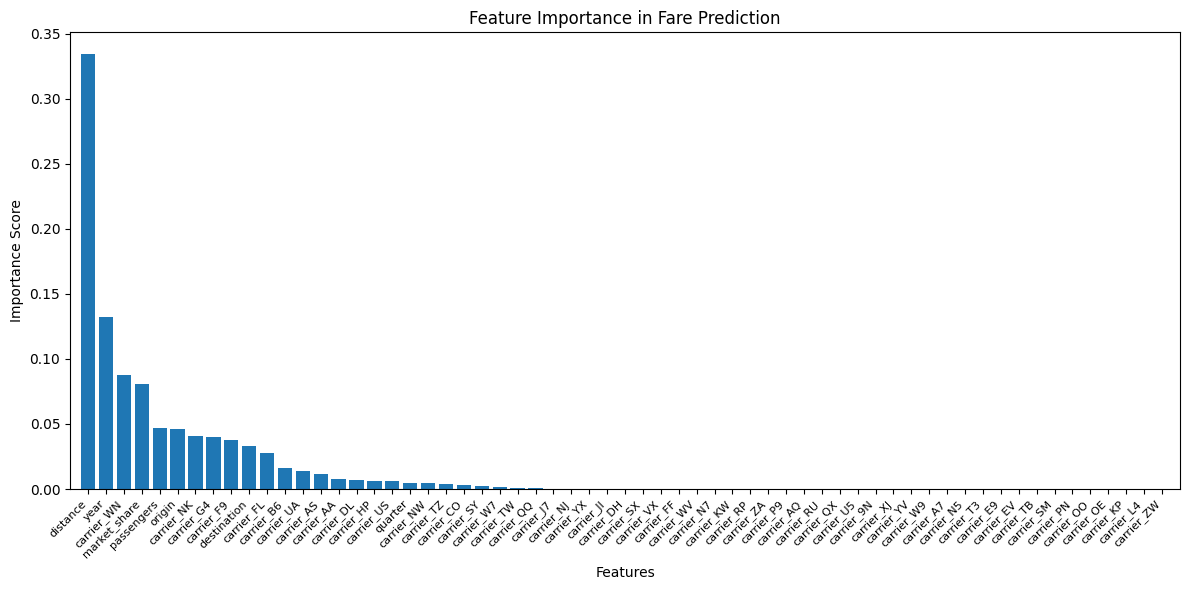

In [36]:
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(importances['feature'], importances['importance'])
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance in Fare Prediction')
plt.margins(x=0.01) 
plt.tight_layout()
plt.show()

## Simple Neural Network 

Training neural network model...
Iteration 1, loss = 2111.33510838
Validation score: 0.613308
Iteration 2, loss = 817.92339655
Validation score: 0.638399
Iteration 3, loss = 760.33097592
Validation score: 0.666280
Iteration 4, loss = 708.64138348
Validation score: 0.676637
Iteration 5, loss = 681.83116566
Validation score: 0.694027
Iteration 6, loss = 656.90827609
Validation score: 0.705336
Iteration 7, loss = 641.29887607
Validation score: 0.702659
Iteration 8, loss = 628.81739650
Validation score: 0.717005
Iteration 9, loss = 618.01605561
Validation score: 0.715345
Iteration 10, loss = 608.79754449
Validation score: 0.714000
Iteration 11, loss = 595.52300287
Validation score: 0.730310
Iteration 12, loss = 588.59624573
Validation score: 0.730563
Iteration 13, loss = 609.25398447
Validation score: 0.731619
Iteration 14, loss = 576.63575374
Validation score: 0.738784
Iteration 15, loss = 565.04415058
Validation score: 0.734012
Iteration 16, loss = 560.90472046
Validation score: 0.740453

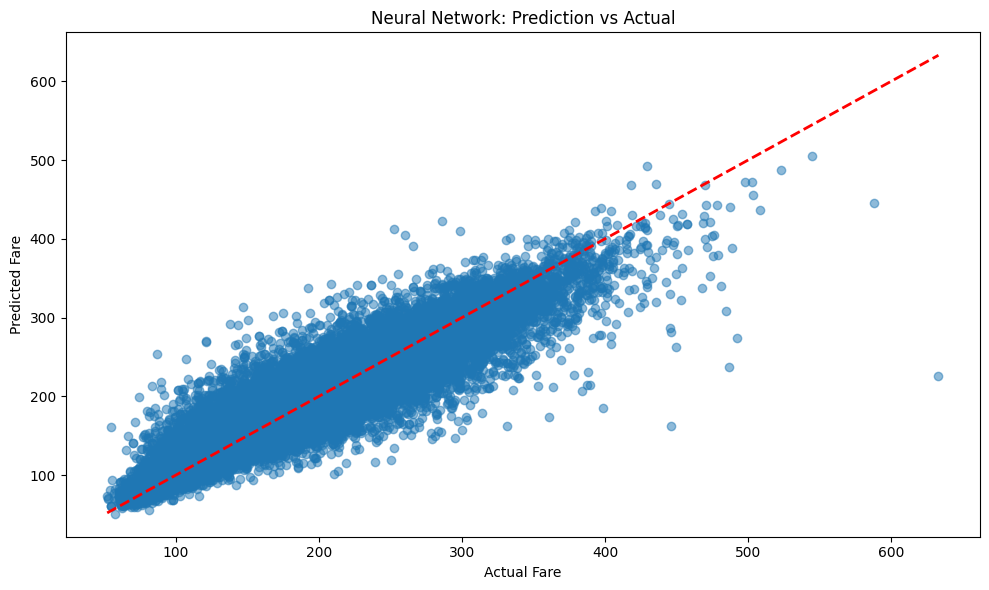

In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

def train_neural_network(X, y):
    """Train and evaluate a neural network model"""
    # Define feature order
    feature_order = ['distance', 'year', 'quarter', 'passengers', 'origin', 'destination', 'market_share',
                    'carrier_9N', 'carrier_A7', 'carrier_AA', 'carrier_AQ', 'carrier_AS', 
                    'carrier_B6', 'carrier_CO', 'carrier_DH', 'carrier_DL', 'carrier_E9', 
                    'carrier_EV', 'carrier_F9', 'carrier_FF', 'carrier_FL', 'carrier_G4', 
                    'carrier_HP', 'carrier_J7', 'carrier_JI', 'carrier_KP', 'carrier_KW', 
                    'carrier_L4', 'carrier_N5', 'carrier_N7', 'carrier_NJ', 'carrier_NK', 
                    'carrier_NW', 'carrier_OE', 'carrier_OO', 'carrier_P9', 'carrier_PN', 
                    'carrier_QQ', 'carrier_QX', 'carrier_RP', 'carrier_RU', 'carrier_SM', 
                    'carrier_SX', 'carrier_SY', 'carrier_T3', 'carrier_TB', 'carrier_TW', 
                    'carrier_TZ', 'carrier_U5', 'carrier_UA', 'carrier_US', 'carrier_VX', 
                    'carrier_W7', 'carrier_W9', 'carrier_WN', 'carrier_WV', 'carrier_XJ', 
                    'carrier_YV', 'carrier_YX', 'carrier_ZA', 'carrier_ZW']
    
    # Ensure X has correct column order
    X = X[feature_order]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    # Create and train the model
    nn_model = MLPRegressor(
        hidden_layer_sizes=(256, 128, 128),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2,
        verbose=True
    )
    
    nn_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = nn_model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f"\nNeural Network Metrics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2)
    plt.xlabel('Actual Fare')
    plt.ylabel('Predicted Fare')
    plt.title('Neural Network: Prediction vs Actual')
    plt.tight_layout()
    plt.show()
    
    return nn_model, scaler, feature_order

def predict_route_fare_nn(nn_model, scaler, origin_city, dest_city, year, quarter, 
                         passengers, carrier, origin_encoder, dest_encoder, 
                         carrier_list, faresByCity_df, carriers_df, feature_order):
    """Predict fare using the neural network model independently"""
    try:
        # Check if direct route exists
        direct_route = faresByCity_df[
            (faresByCity_df['city1'] == origin_city) & 
            (faresByCity_df['city2'] == dest_city)
        ]
        
        route_exists = len(direct_route) > 0
        if route_exists:
            distance = direct_route['nsmiles'].iloc[0]
            route_carriers = {
                direct_route['carrier_lg'].iloc[0], 
                direct_route['carrier_low'].iloc[0]
            }
            carrier_serves_route = carrier in route_carriers
            
            if carrier == direct_route['carrier_lg'].iloc[0]:
                market_share = direct_route['large_ms'].iloc[0]
            elif carrier == direct_route['carrier_low'].iloc[0]:
                market_share = direct_route['lf_ms'].iloc[0]
            else:
                market_share = 0.5
        else:
            origin_coords = get_city_coordinates(origin_city, faresByCity_df, is_origin=True)
            dest_coords = get_city_coordinates(dest_city, faresByCity_df, is_origin=False)
            distance = calculate_distance(origin_coords, dest_coords)
            carrier_serves_route = False
            market_share = 0.5
            
        # Initialize features dictionary
        features_dict = {
            'distance': distance,
            'year':year,
            'quarter': quarter,
            'passengers': passengers,
            'origin': origin_encoder.transform([origin_city])[0],
            'destination': dest_encoder.transform([dest_city])[0],
            'market_share': market_share
        }
        
        # Add carrier features in the correct order
        for feat in feature_order:
            if feat.startswith('carrier_'):
                features_dict[feat] = 1 if f'carrier_{carrier}' == feat else 0
        
        # Create DataFrame with exact feature order
        X_pred = pd.DataFrame([features_dict])[feature_order]
        
        # Scale features
        X_pred_scaled = scaler.transform(X_pred)
        
        # Make prediction
        predicted_fare = nn_model.predict(X_pred_scaled)[0]
        
        return {
            'predicted_fare': f"${predicted_fare:.2f}",
            'distance': f"{distance:.1f} miles",
            'origin': origin_city,
            'destination': dest_city,
            'carrier': carrier,
            'quarter': f"Q{quarter}",
            'passengers': passengers,
            'route_exists': route_exists,
            'carrier_serves_route': carrier_serves_route,
            'market_share': f"{market_share*100:.1f}%"
        }
        
    except Exception as e:
        print(f"Debug - Expected features: {feature_order}")
        print(f"Debug - Input features: {list(X_pred.columns) if 'X_pred' in locals() else 'Not created'}")
        return f"Error making prediction: {str(e)}"

# Train the model
print("Training neural network model...")
nn_model, feature_scaler, feature_order = train_neural_network(X, y)

#### Prediction for flight price using neural network

In [38]:
# Test the prediction
test_pred_nn = predict_route_fare_nn(
    nn_model=nn_model,
    scaler=feature_scaler,
    origin_city="Denver, CO",
    dest_city="Seattle, WA",
    year="2014",
    quarter=4,
    passengers=500,
    carrier="DL",
    origin_encoder=origin_encoder,
    dest_encoder=dest_encoder,
    carrier_list=carrier_list,
    faresByCity_df=faresByCity_df_original,
    carriers_df=carriers_df,
    feature_order=feature_order
)

print(test_pred_nn)

{'predicted_fare': '$267.45', 'distance': '1024.0 miles', 'origin': 'Denver, CO', 'destination': 'Seattle, WA', 'carrier': 'DL', 'quarter': 'Q4', 'passengers': 500, 'route_exists': True, 'carrier_serves_route': False, 'market_share': '50.0%'}


In [39]:
# Look up specific Frontier route in Q1
frontier_specific = faresByCity_df[
   (((faresByCity_df['city1'] == 'Denver, CO') & (faresByCity_df['city2'] == 'Seattle, WA')) |
    ((faresByCity_df['city2'] == 'Denver, CO') & (faresByCity_df['city1'] == 'Seattle, WA'))) &
   (faresByCity_df['carrier_lg'] == 'F9') &
   (faresByCity_df['Year'] == 2014)  # Add year filter
]

print(frontier_specific[['city1', 'city2', 'Year', 'quarter', 'fare', 'carrier_lg', 'fare_lg', 'carrier_low', 'fare_low']])

           city1        city2  Year  quarter    fare carrier_lg  fare_lg  \
7534  Denver, CO  Seattle, WA  2014        4  180.71         F9   140.07   

     carrier_low  fare_low  
7534          F9    140.07  


## Uncovering other Trends

#### Analysis of difference between quarters


Quarterly Fare Analysis:

Lowest average fares: Q3 ($195.06)
Highest average fares: Q2 ($200.19)


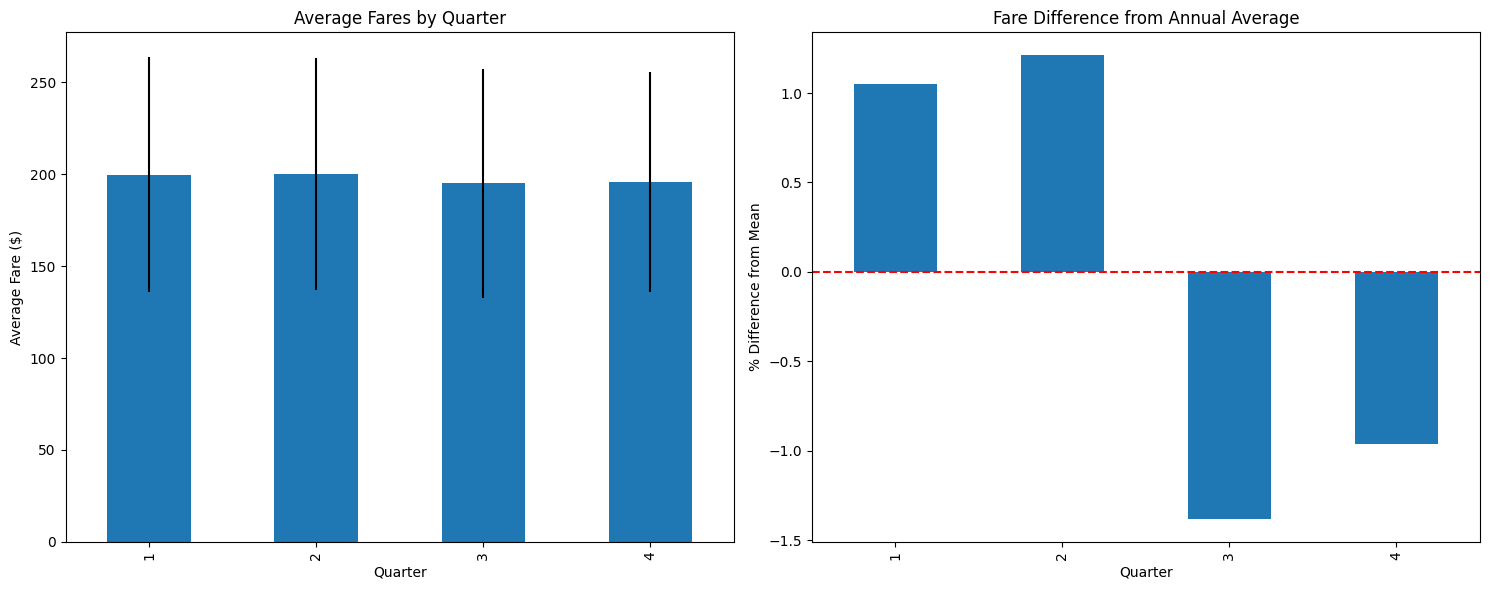

In [40]:
#Analysis of quarterly fares
def analyze_quarterly_trends(faresByCity_df):
    """Analyze fare trends by quarter to determine best time to buy"""
    
    # Calculate comprehensive quarterly statistics
    quarterly_stats = faresByCity_df.groupby('quarter').agg({
        'fare': ['mean', 'std', 'min', 'max', 'count'],
        'passengers': ['sum', 'mean']
    }).round(2)
    
    # Calculate percentage difference from average fare
    overall_mean = faresByCity_df['fare'].mean()
    quarterly_means = faresByCity_df.groupby('quarter')['fare'].mean()
    percent_diff = ((quarterly_means - overall_mean) / overall_mean * 100).round(2)
    
    print("\nQuarterly Fare Analysis:")
    print(f"\nLowest average fares: Q{quarterly_means.idxmin()} (${quarterly_means.min():.2f})")
    print(f"Highest average fares: Q{quarterly_means.idxmax()} (${quarterly_means.max():.2f})")
    
    # Visualize the findings
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Average fares by quarter with error bars
    quarterly_means.plot(kind='bar', yerr=quarterly_stats['fare']['std'], ax=ax1)
    ax1.set_title('Average Fares by Quarter')
    ax1.set_xlabel('Quarter')
    ax1.set_ylabel('Average Fare ($)')
    
    # Plot 2: Percentage difference from mean
    percent_diff.plot(kind='bar', ax=ax2)
    ax2.set_title('Fare Difference from Annual Average')
    ax2.set_xlabel('Quarter')
    ax2.set_ylabel('% Difference from Mean')
    ax2.axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    return quarterly_stats, percent_diff

# Run the analysis
stats, diffs = analyze_quarterly_trends(faresByCity_df)

## Error Analysis of predictions

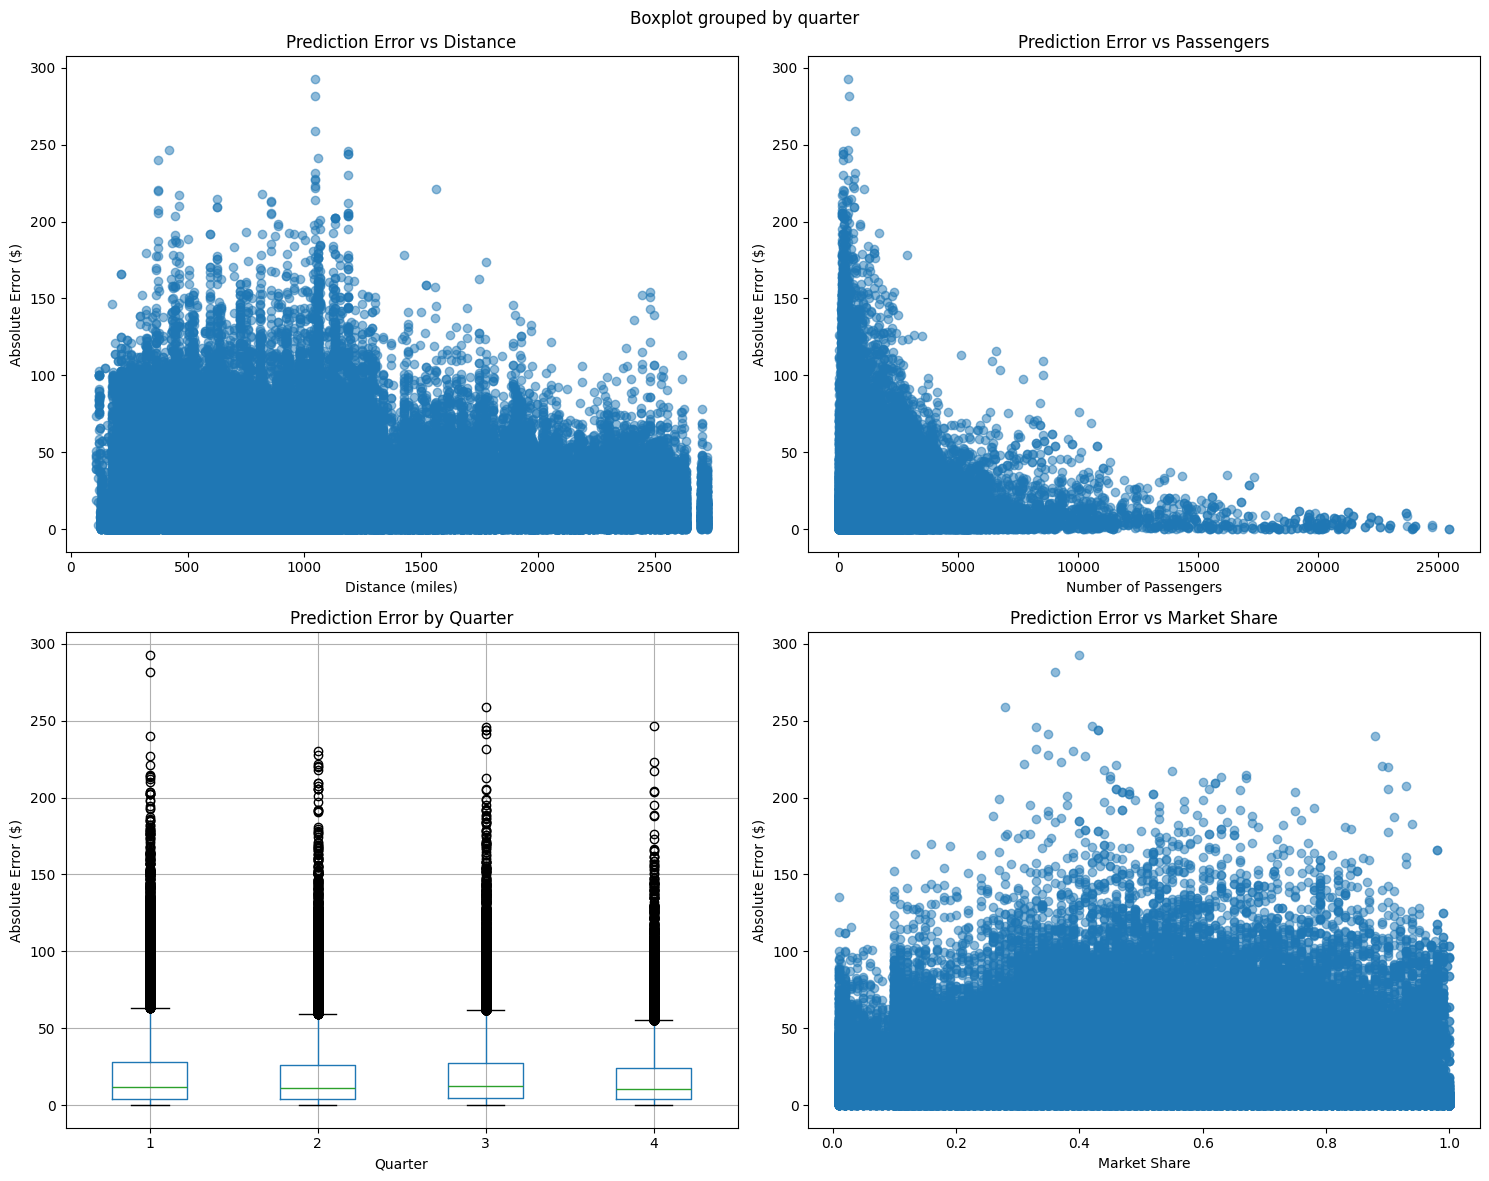


Error Analysis Summary:
Mean Absolute Error: $19.12
Median Error: $11.55
Standard Deviation of Error: $21.75

Errors by Distance Range:
distance
(108.999, 496.0]    16.53
(496.0, 783.0]      21.53
(783.0, 1059.0]     21.26
(1059.0, 1599.0]    19.48
(1599.0, 2724.0]    16.82
Name: error, dtype: float64


/var/folders/nx/kkfl1r5j50d87vvmlqgnfk5m0000gn/T/ipykernel_65552/3102674315.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(error_df.groupby(distance_bins)['error'].mean().round(2))


In [41]:
def analyze_prediction_errors(model, X, y):
    """Analyze where and how the model makes errors"""
    # Make predictions
    predictions = model.predict(X)
    errors = abs(predictions - y)
    
    # Create error analysis dataframe
    error_df = pd.DataFrame({
        'actual_fare': y,
        'predicted_fare': predictions,
        'error': errors,
        'distance': X['distance'],
        'passengers': X['passengers'],
        'quarter': X['quarter'],
        'market_share': X['market_share']
    })
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Error vs Distance
    axes[0,0].scatter(error_df['distance'], error_df['error'], alpha=0.5)
    axes[0,0].set_title('Prediction Error vs Distance')
    axes[0,0].set_xlabel('Distance (miles)')
    axes[0,0].set_ylabel('Absolute Error ($)')
    
    # 2. Error vs Passengers
    axes[0,1].scatter(error_df['passengers'], error_df['error'], alpha=0.5)
    axes[0,1].set_title('Prediction Error vs Passengers')
    axes[0,1].set_xlabel('Number of Passengers')
    axes[0,1].set_ylabel('Absolute Error ($)')
    
    # 3. Error by Quarter
    error_df.boxplot(column='error', by='quarter', ax=axes[1,0])
    axes[1,0].set_title('Prediction Error by Quarter')
    axes[1,0].set_xlabel('Quarter')
    axes[1,0].set_ylabel('Absolute Error ($)')
    
    # 4. Error vs Market Share
    axes[1,1].scatter(error_df['market_share'], error_df['error'], alpha=0.5)
    axes[1,1].set_title('Prediction Error vs Market Share')
    axes[1,1].set_xlabel('Market Share')
    axes[1,1].set_ylabel('Absolute Error ($)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nError Analysis Summary:")
    print(f"Mean Absolute Error: ${error_df['error'].mean():.2f}")
    print(f"Median Error: ${error_df['error'].median():.2f}")
    print(f"Standard Deviation of Error: ${error_df['error'].std():.2f}")
    
    # Analyze errors by distance ranges
    distance_bins = pd.qcut(error_df['distance'], q=5)
    print("\nErrors by Distance Range:")
    print(error_df.groupby(distance_bins)['error'].mean().round(2))
    
    return error_df

# Run the analysis
error_analysis = analyze_prediction_errors(model, X, y)

# Putting it all together for a full prediction tool 

In [46]:
def predict_airfare(origin_city, dest_city, year, quarter, passengers, carrier,
                   rf_model, nn_model, feature_scaler, origin_encoder, dest_encoder,
                   carrier_list, faresByCity_df, carriers_df, feature_order):
    """
    Get predictions from both random forest and neural network models
    """
    # Get random forest prediction
    rf_pred = predict_route_fare(
        model=rf_model,
        origin_city=origin_city,
        dest_city=dest_city,
        year=year,
        quarter=quarter,
        passengers=passengers,
        carrier=carrier,
        origin_encoder=origin_encoder,
        dest_encoder=dest_encoder,
        carrier_list=carrier_list,
        faresByCity_df=faresByCity_df,
        carriers_df=carriers_df
    )
    
    # Get neural network prediction
    nn_pred = predict_route_fare_nn(
        nn_model=nn_model,
        scaler=feature_scaler,
        origin_city=origin_city,
        dest_city=dest_city,
        year=year,
        quarter=quarter,
        passengers=passengers,
        carrier=carrier,
        origin_encoder=origin_encoder,
        dest_encoder=dest_encoder,
        carrier_list=carrier_list,
        faresByCity_df=faresByCity_df,
        carriers_df=carriers_df,
        feature_order=feature_order
    )

    return {
        'random_forest': rf_pred,
        'neural_network': nn_pred
    }

In [47]:
predictions = predict_airfare(
    origin_city="Atlanta, GA (Metropolitan Area)",
    dest_city="Seattle, WA",
    year="2009",
    quarter=4,
    passengers=100,
    carrier="F9",
    rf_model=model,
    nn_model=nn_model,
    feature_scaler=feature_scaler,
    origin_encoder=origin_encoder,
    dest_encoder=dest_encoder,
    carrier_list=carrier_list,
    faresByCity_df=faresByCity_df_original,
    carriers_df=carriers_df,
    feature_order=feature_order
)

In [48]:
print(predictions)

{'random_forest': {'predicted_fare': '$270.74', 'distance': '2182.0 miles', 'origin': 'Atlanta, GA (Metropolitan Area)', 'destination': 'Seattle, WA', 'carrier': 'F9', 'quarter': 'Q4', 'passengers': 100, 'route_exists': True, 'carrier_serves_route': False, 'market_share': '50.0%'}, 'neural_network': {'predicted_fare': '$195.35', 'distance': '2182.0 miles', 'origin': 'Atlanta, GA (Metropolitan Area)', 'destination': 'Seattle, WA', 'carrier': 'F9', 'quarter': 'Q4', 'passengers': 100, 'route_exists': True, 'carrier_serves_route': False, 'market_share': '50.0%'}}


In [54]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import pandas as pd
from typing import List, Union

def find_closest_city(input_city: str, city_list: List[str]) -> Union[str, float, tuple]:
    """
    Find the closest city in training set to an input city
    
    Args:
        input_city: City to find match for
        city_list: List of cities in training set
        
    Returns:
        tuple: (closest_city, distance_miles, input_coordinates)
    """
    # Initialize geocoder
    geolocator = Nominatim(user_agent="my_airfare_predictor")
    
    # Get coordinates for input city
    try:
        input_location = geolocator.geocode(input_city)
        input_coords = (input_location.latitude, input_location.longitude)
    except:
        return f"Could not find coordinates for {input_city}"
    
    # Find closest city
    min_distance = float('inf')
    closest_city = None
    
    for city in city_list:
        try:
            city_location = geolocator.geocode(city)
            city_coords = (city_location.latitude, city_location.longitude)
            
            # Calculate distance
            distance = geodesic(input_coords, city_coords).miles
            
            if distance < min_distance:
                min_distance = distance
                closest_city = city
                
        except:
            continue
            
    return (closest_city, min_distance, input_coords)

In [57]:
test_city = "Denver, CO"
closest_match = find_closest_city(test_city, origin_cities)
print(f"Input city: {test_city}")
print(f"Closest city in training set: {closest_match[0]}")
print(f"Distance: {closest_match[1]:.2f} miles")

Input city: Denver, CO
Closest city in training set: Denver, CO
Distance: 0.00 miles


In [67]:
def predict_airfare(origin_city, dest_city, year, quarter, passengers, carrier,
                   rf_model, nn_model, feature_scaler, origin_encoder, dest_encoder,
                   carrier_list, faresByCity_df, carriers_df, feature_order):
    """
    Get predictions from both random forest and neural network models,
    handling cities not in training set by using their closest matches
    """
    # Initialize geocoder
    geolocator = Nominatim(user_agent="my_airfare_predictor")
    
    # Check if cities are in training sets and find closest if not
    origin_substitute = None
    dest_substitute = None
    
    # Get actual coordinates for distance calculation
    try:
        origin_location = geolocator.geocode(origin_city)
        dest_location = geolocator.geocode(dest_city)
        actual_distance = geodesic(
            (origin_location.latitude, origin_location.longitude),
            (dest_location.latitude, dest_location.longitude)
        ).miles
    except:
        actual_distance = None

    # Handle origin city
    if origin_city not in origin_cities:
        closest = find_closest_city(origin_city, origin_cities)
        if isinstance(closest, tuple):
            origin_substitute = closest[0]
            print(f"Using {origin_substitute} as substitute for {origin_city}")

    # Handle destination city
    if dest_city not in destination_cities:
        closest = find_closest_city(dest_city, destination_cities)
        if isinstance(closest, tuple):
            dest_substitute = closest[0]
            print(f"Using {dest_substitute} as substitute for {dest_city}")

    # Get random forest prediction
    rf_pred = predict_route_fare(
        model=rf_model,
        origin_city=origin_substitute if origin_substitute else origin_city,
        dest_city=dest_substitute if dest_substitute else dest_city,
        year=year,
        quarter=quarter,
        passengers=passengers,
        carrier=carrier,
        origin_encoder=origin_encoder,
        dest_encoder=dest_encoder,
        carrier_list=carrier_list,
        faresByCity_df=faresByCity_df,
        carriers_df=carriers_df
    )
    
    # Get neural network prediction
    nn_pred = predict_route_fare_nn(
        nn_model=nn_model,
        scaler=feature_scaler,
        origin_city=origin_substitute if origin_substitute else origin_city,
        dest_city=dest_substitute if dest_substitute else dest_city,
        year=year,
        quarter=quarter,
        passengers=passengers,
        carrier=carrier,
        origin_encoder=origin_encoder,
        dest_encoder=dest_encoder,
        carrier_list=carrier_list,
        faresByCity_df=faresByCity_df,
        carriers_df=carriers_df,
        feature_order=feature_order
    )

    result = {
        'random_forest': rf_pred,
        'neural_network': nn_pred,
        'substitutions': {}
    }

    # Add substitution information to result
    if origin_substitute:
        result['substitutions']['origin'] = {
            'original': origin_city,
            'substitute': origin_substitute
        }
    if dest_substitute:
        result['substitutions']['destination'] = {
            'original': dest_city,
            'substitute': dest_substitute
        }
    if actual_distance:
        result['actual_distance'] = actual_distance

    return result

In [68]:
import json
test_prediction = predict_airfare(
    origin_city="Rome, Italy",
    dest_city="Denver, CO",
    year="2023",
    quarter=4,
    passengers=100,
    carrier="DL",
    rf_model=model,
    nn_model=nn_model,
    feature_scaler=feature_scaler,
    origin_encoder=origin_encoder,
    dest_encoder=dest_encoder,
    carrier_list=carrier_list,
    faresByCity_df=faresByCity_df_original,
    carriers_df=carriers_df,
    feature_order=feature_order
)

print("Prediction Results:")
print(json.dumps(test_prediction, indent=2))

Using Bangor, ME as substitute for Rome, Italy
Prediction Results:
{
  "random_forest": {
    "predicted_fare": "$311.90",
    "distance": "1872.9 miles",
    "origin": "Bangor, ME",
    "destination": "Denver, CO",
    "carrier": "DL",
    "quarter": "Q4",
    "passengers": 100,
    "route_exists": false,
    "carrier_serves_route": false,
    "market_share": "50.0%"
  },
  "neural_network": {
    "predicted_fare": "$328.31",
    "distance": "1872.9 miles",
    "origin": "Bangor, ME",
    "destination": "Denver, CO",
    "carrier": "DL",
    "quarter": "Q4",
    "passengers": 100,
    "route_exists": false,
    "carrier_serves_route": false,
    "market_share": "50.0%"
  },
  "substitutions": {
    "origin": {
      "original": "Rome, Italy",
      "substitute": "Bangor, ME"
    }
  },
  "actual_distance": 5584.583383391608
}
